In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [2]:
import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import itertools

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

# EDA

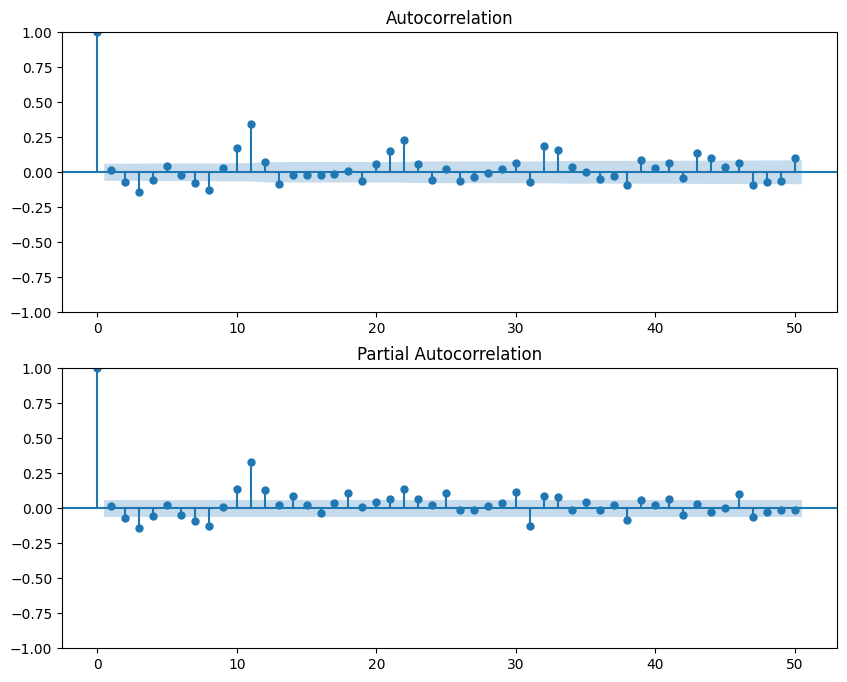

In [3]:
filepath = "new-shell-cashflow-datathon-2023"
# filepath = "/kaggle/input/new-shell-cashflow-datathon-2023/"
train_set = pd.read_csv(f'{filepath}/cash_flow_train.csv', index_col="Date")
train_endog = pd.DataFrame(train_set["Net Cashflow from Operations"], columns=["Net Cashflow from Operations"])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_endog["Net Cashflow from Operations"], ax=ax1, lags=50)
plot_pacf(train_endog["Net Cashflow from Operations"], ax=ax2, lags=50)
plt.show()


In [4]:
# Seasonal Decomposition
train_endog.index = pd.to_datetime(train_endog.index)
train_endog = train_endog.asfreq('D').fillna(0)
res = seasonal_decompose(train_endog[train_endog.index >= "2021-01-04"], model='additive')

# Extract the seasonality component
seasonality = res.seasonal

In [5]:
seasonal_periods = []
for i in range(2, len(seasonality) // 2):
    autocorr = np.abs(acf(seasonality, nlags=i, fft=True))
    if autocorr[-1] > 2 / np.sqrt(len(seasonality)):
        seasonal_periods.append(i)

# Print the dominant seasonal periods
print("Dominant seasonal periods found:", seasonal_periods)

Dominant seasonal periods found: [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28, 30, 31, 32, 33, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 49, 51, 52, 53, 54, 56, 58, 59, 60, 61, 63, 65, 66, 67, 68, 70, 72, 73, 74, 75, 77, 79, 80, 81, 82, 84, 86, 87, 88, 89, 91, 93, 94, 95, 96, 98, 100, 101, 102, 103, 105, 107, 108, 109, 110, 112, 114, 115, 116, 117, 119, 121, 122, 123, 124, 126, 128, 129, 130, 131, 133, 135, 136, 137, 138, 140, 142, 143, 144, 145, 147, 149, 150, 151, 152, 154, 156, 157, 158, 159, 161, 163, 164, 165, 166, 168, 170, 171, 172, 173, 175, 177, 178, 179, 180, 182, 184, 185, 186, 187, 189, 191, 192, 193, 194, 196, 198, 199, 200, 201, 203, 205, 206, 207, 208, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 224, 226, 227, 228, 229, 231, 233, 234, 235, 236, 238, 240, 241, 242, 243, 245, 247, 248, 249, 250, 252, 254, 255, 256, 257, 259, 261, 262, 263, 264, 266, 268, 269, 270, 271, 273, 275, 276, 277, 278, 280, 282, 283, 284, 285, 287, 289, 290, 291,

In [6]:
train_endog.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1492 entries, 2019-01-02 to 2023-02-01
Freq: D
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Net Cashflow from Operations  1492 non-null   float64
dtypes: float64(1)
memory usage: 23.3 KB


In [7]:
train_endog.describe()

,Net Cashflow from Operations
count,1.492000e+03
mean,9.312413e+06
std,4.892087e+07
min,-2.788637e+08
25%,0.000000e+00
50%,0.000000e+00
75%,1.834807e+07
max,3.857215e+08


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

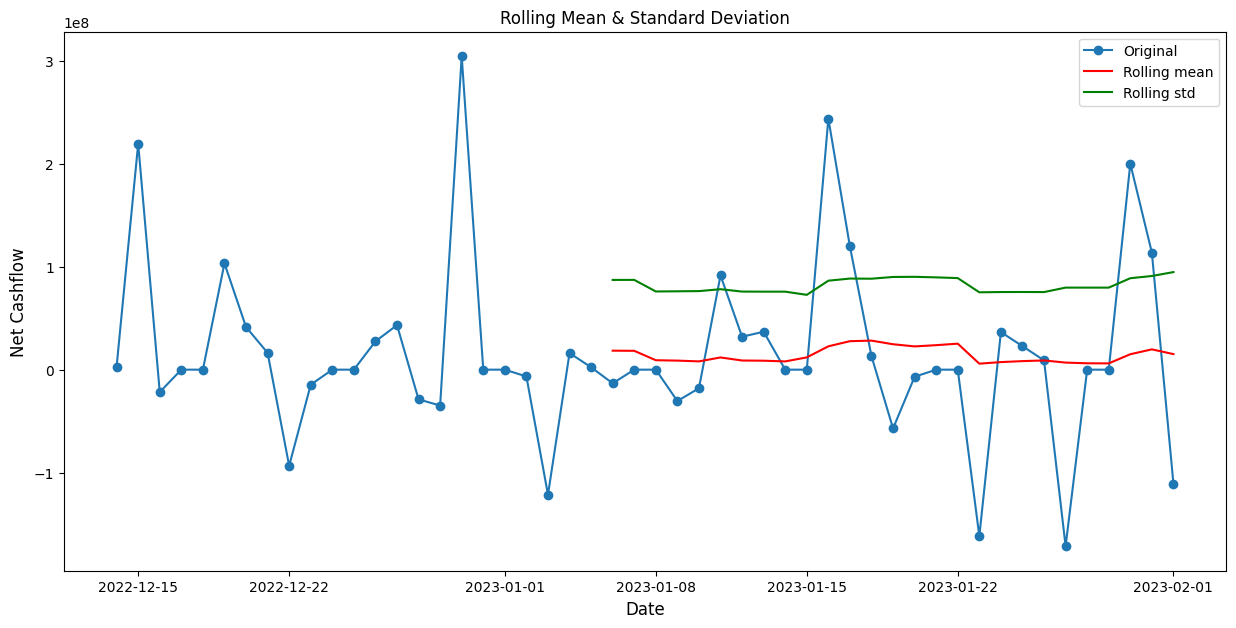

In [8]:
### Mean and STD Plot
plt.figure(figsize=(15,7))
plt.plot(train_endog[-50:], label='Original',marker = "o")
plt.plot(train_endog[-50:].rolling(window=24).mean(), color='red' ,label='Rolling mean')
plt.plot(train_endog[-50:].rolling(window=24).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net Cashflow', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [9]:
###Dickey-Fuller Test for Checking Stationary
def DF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Samples",
        ],
    )
    for k, val in dftest[4].items():
        dfoutput["Critical Value (%s)" % k] = val
    print(dfoutput)
    if dfoutput["p-value"] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [10]:
DF_test(train_endog)

Results of Dickey-Fuller Test:
Test Statistic         -5.807312e+00
p-value                 4.485107e-07
Lags Used               1.800000e+01
Number of Samples       1.473000e+03
Critical Value (1%)    -3.434797e+00
Critical Value (5%)    -2.863504e+00
Critical Value (10%)   -2.567816e+00
dtype: float64
Data is stationary


*Data'nın Stationary olduğunu biliyoruz ve PACF ve ACF grafiklerinden olası seasonalityleri de elde etmiş bulunuyoruz*

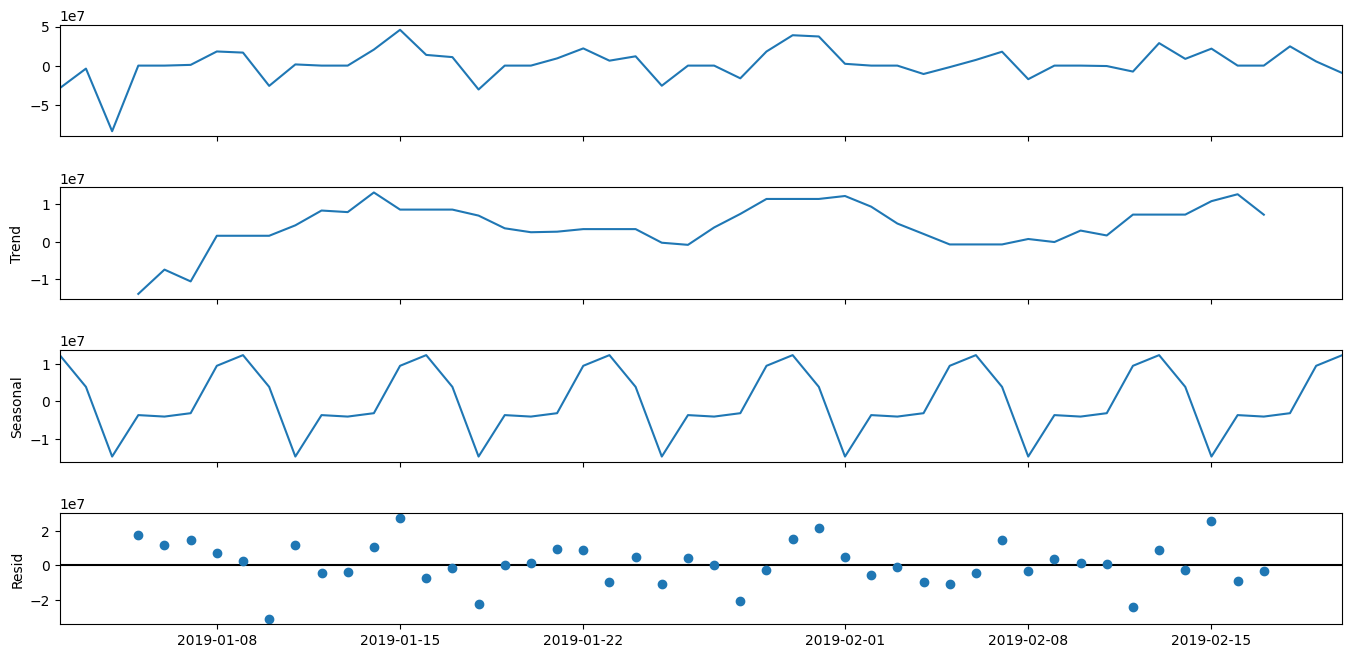

In [11]:
###seasonal decomposition
def seasonal_decomp(df):
    decomp = sm.tsa.seasonal.seasonal_decompose(df,model = "additive")
    seasonal = decomp.seasonal
    trend = decomp.trend
    residual = decomp.resid
    decomp_f = decomp.plot()
    decomp_f.set_size_inches(15,7)
    plt.show()
    return seasonal,trend,residual


seasonal,trend,residual = seasonal_decomp(train_endog[:50])

*Seasonality ve Noise kesin bir şekilde görülebiliyor fakat trend düzensiz*

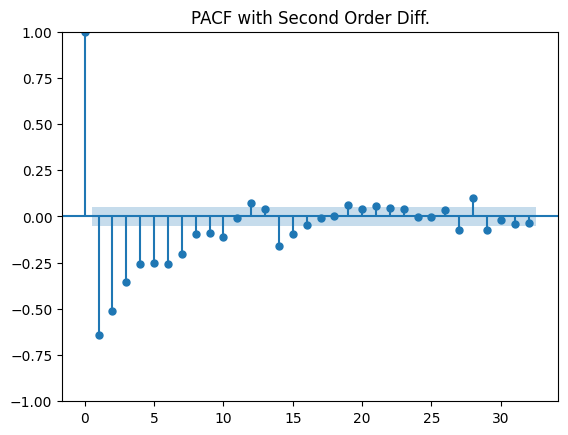

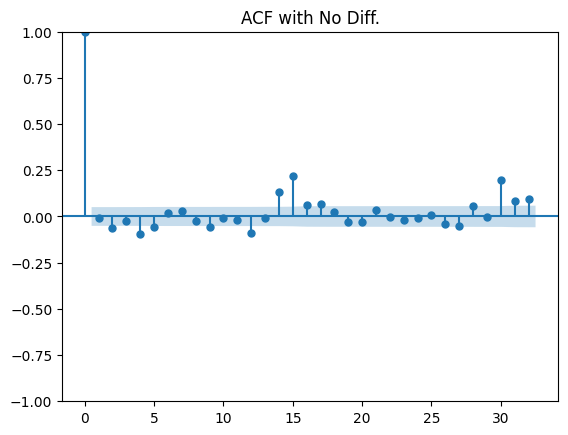

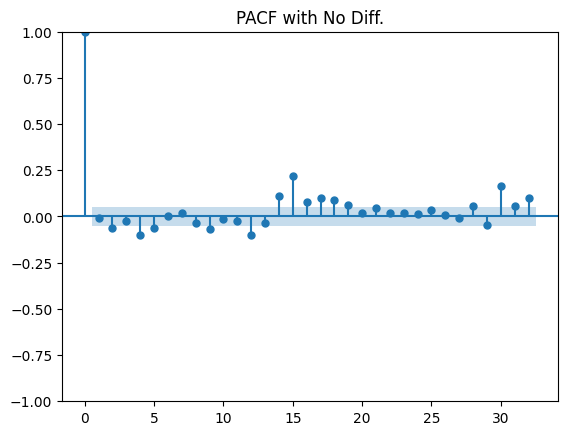

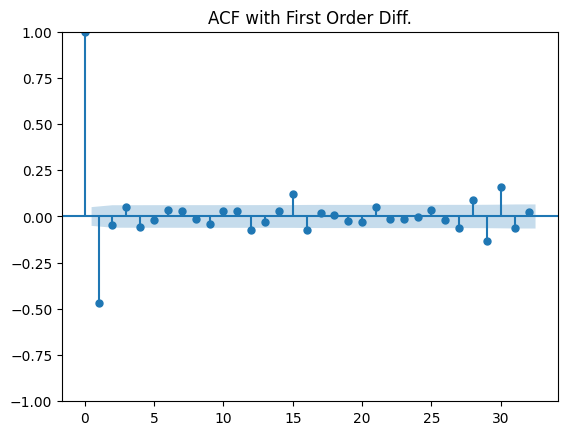

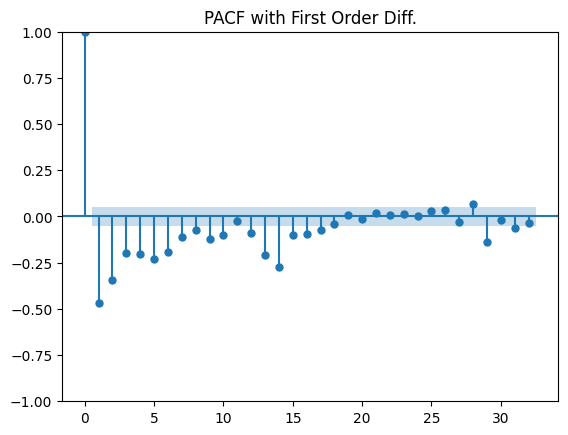

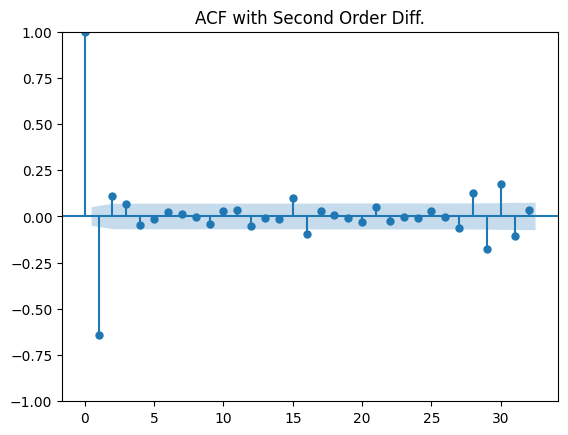

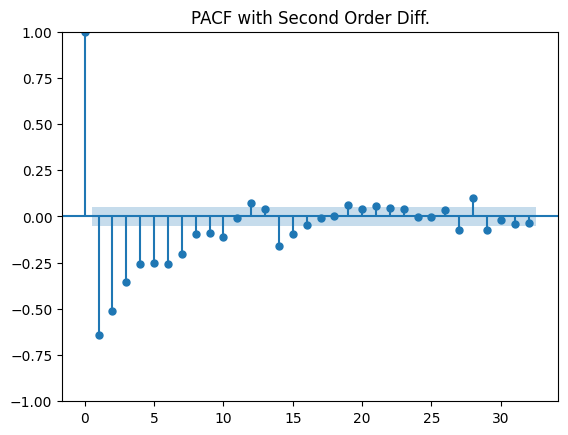

In [12]:
###AutoCorrelation and Partial AutoCorrelation
plot_acf(train_endog,alpha=.05,title = "ACF with No Diff.")
plot_pacf(train_endog,alpha=.05,title = "PACF with No Diff.")
### First order diff
plot_acf(train_endog.diff().dropna(),alpha=.05,title = "ACF with First Order Diff.")
plot_pacf(train_endog.diff().dropna(),alpha=.05,title = "PACF with First Order Diff.")
### Second order diff
plot_acf(train_endog.diff().diff().dropna(),alpha=.05,title = "ACF with Second Order Diff.")
plot_pacf(train_endog.diff().diff().dropna(),alpha=.05,title = "PACF with Second Order Diff.")

*Elimizde Test seti için kullanabileceğimiz feature'lar olmadığından(Çünkü forecast horizon 70'ken lag,mean,std,ma window gibi featurelar bir anlam ifade etmiyor) ve gerçekleşmiş ötv,dolar vb. gibi kullanılamadığından tarih bazlı featurelarla problem çözülmeye çalışılacaktır.*

# Feature Engineering

In [13]:
def transform_day_of_week(df):
    df.index = pd.to_datetime(df.index)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
#     df['day_of_month_sin'] = np.sin(2 * np.pi * df.index.day / 30)
#     df['day_of_month_cos'] = np.cos(2 * np.pi * df.index.day / 30)
    df['is_monday'] = (df.index.dayofweek == 1).astype(int)
    df['is_friday'] = (df.index.dayofweek == 4).astype(int)
#     df['is_saturday'] = (df.index.dayofweek == 5).astype(int)
#     df['is_sunday'] = (df.index.dayofweek == 6).astype(int)
    return df

In [14]:
train_exog = train_endog.copy()
test_set = pd.read_csv(f'{filepath}/sample_submission.csv', index_col="Date")
train_exog = pd.concat([train_exog, test_set], axis=0)
train_exog.index = pd.to_datetime(train_exog.index)
train_exog = train_exog.asfreq('D').fillna(0)
train_exog = transform_day_of_week(train_exog)
turkish_holidays = holidays.Turkey(years=train_exog.index.year.unique())

# create a holiday feature

In [15]:
train_exog['Date'] = train_exog.index
train_exog['is_holiday'] = train_exog['Date'].apply(lambda x: x in turkish_holidays).astype(int)
train_exog.drop(["Date"], axis=1, inplace=True)
train_exog["Net Cashflow from Operations"] = train_exog["Net Cashflow from Operations"].astype("float64")

# Create Test Exogeneous and Train Exogeneous and Endogeneous Features

In [16]:
train_exog = train_exog.drop("Net Cashflow from Operations", axis=1)
train_exog.index = pd.to_datetime(train_exog.index)
test_exog = train_exog[train_exog.index >= "2023-02-02"]
train_exog = train_exog[train_exog.index < "2023-02-02"]
train_endog = train_endog.dropna()

In [17]:
# output_filepath = "/kaggle/working"
output_filepath = filepath
train_exog.to_csv(f'{output_filepath}/train_exog.csv')
train_endog.to_csv(f'{output_filepath}/train_endog.csv')

# Parameter Search For SARIMAX

In [18]:
p_values = range(0, 3)  # Replace with the desired range of p values
q_values = range(0, 3)  # Replace with the desired range of q values
d_values = range(0, 3)  # Replace with the desired range of d values
P_values = range(0, 3)  # Replace with the desired range of P values
D_values = range(0, 3)  # Replace with the desired range of D values
Q_values = range(0, 3)  # Replace with the desired range of Q values

parameters = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods[:5]))
best_aic = float("inf")
best_params = None

for param in tqdm(parameters):
    try:
        # Fit the SARIMAX model with the current combination of parameters
        model = SARIMAX(train_endog[train_endog.index >= "2021-01-01"],
                        exog=train_exog[train_exog.index >= "2021-01-01"], order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]))
        results = model.fit()

        # Calculate the AIC score for the model
        aic = results.aic

        # Update the best AIC and parameters if the current model has a lower AIC
        if aic < best_aic:
            best_aic = aic
            best_params = param

    except Exception as e:
        continue

# Print the best parameters and AIC value
print("Best Parameters:", best_params)
print("AIC:", best_aic)

100%|██████████| 3645/3645 [1:12:22<00:00,  1.19s/it]

Best Parameters: (1, 0, 1, 2, 2, 2, 4)
AIC: 24.0


In [19]:
model = SARIMAX(train_endog[train_endog.index >= "2021-01-01"], exog=train_exog[train_exog.index >= "2021-01-01"],
                order=(1, 0, 1), seasonal_order=(2, 2, 2, 4))
model_fit = model.fit()

# Forecast using the trained model
forecast = model_fit.get_forecast(steps=100, exog=test_exog)
forecast_values = forecast.predicted_mean
sample_submission_for_submit = pd.read_csv(f'{filepath}/sample_submission.csv', index_col="Date")
sample_submission = pd.read_csv(f'{filepath}/sample_submission.csv')
forecast_values = forecast_values.drop(index=forecast_values.index.difference(sample_submission_for_submit.index))
sample_submission["Net Cashflow from Operations"] = forecast_values.values
sample_submission.to_csv(f'{output_filepath}/submission_sarimax.csv', index=False)

# Since Our Model is not good enough, we will use an ensemble model with lightgbm and sarimax

# LightGBM Inputs

In [20]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

In [21]:
def transform_day_of_week(df):
    df.index = pd.to_datetime(df.index)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df.index.day / 30)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df.index.day / 30)
    # df['is_monday'] = (df.index.dayofweek == 1).astype(int)
    # df['is_friday'] = (df.index.dayofweek == 4).astype(int)
    # df['is_saturday'] = (df.index.dayofweek == 5).astype(int)
    # df['is_sunday'] = (df.index.dayofweek == 6).astype(int)
    return df

In [22]:
train_exog = train_endog.copy()
test_set = pd.read_csv(f'{filepath}/sample_submission.csv', index_col="Date")
train_exog = pd.concat([train_exog, test_set], axis=0)
train_exog.index = pd.to_datetime(train_exog.index)
train_exog = train_exog.asfreq('D').fillna(0)
train_exog = transform_day_of_week(train_exog)
turkish_holidays = holidays.Turkey(years=train_exog.index.year.unique())

# create a holiday feature

In [23]:
train_exog['Date'] = train_exog.index
train_exog['is_holiday'] = train_exog['Date'].apply(lambda x: x in turkish_holidays).astype(int)
train_exog.drop(["Date"], axis=1, inplace=True)
train_exog["Net Cashflow from Operations"] = train_exog["Net Cashflow from Operations"].astype("float64")

# Create Test Exogeneous and Train Exogeneous and Endogeneous Features

In [24]:
train_exog = train_exog.drop("Net Cashflow from Operations", axis=1)
train_exog.index = pd.to_datetime(train_exog.index)
test_exog = train_exog[train_exog.index >= "2023-02-02"]
train_exog = train_exog[train_exog.index < "2023-02-02"]
train_endog = train_endog.dropna()
# output_filepath = "/kaggle/working"
output_filepath = filepath
train_exog.to_csv(f'{output_filepath}/train_exog.csv')
train_endog.to_csv(f'{output_filepath}/train_endog.csv')

In [26]:
boosting_type = ["goss"]
num_leaves = [15, 31, 63, 127, 255]
max_depth = [3, 5, 7, 15, 31]
learning_rate = [0.1, 0.01, 0.001]
subsample = [0.8, 0.6, 1.0]
colsample_bytree = [0.8, 0.6, 1.0]
reg_alpha = [0.0, 0.1, 0.5]
reg_lambda = [0.0, 0.1, 0.5]
n_estimators = [100, 200, 500]
random_state = [42]
early_stopping_rounds = 100

In [27]:
params = {'objective': ['regression'],
          'boosting_type': boosting_type,
          'num_leaves': num_leaves,
          'max_depth': max_depth,
          'learning_rate': learning_rate,
          'subsample': subsample,
          'colsample_bytree': colsample_bytree,
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda,
          'n_estimators': n_estimators,
          'random_state': random_state,
          'num_iterations': [100, 200, 500]}

# LightGBM Parameter Tuning

In [28]:
model = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=250, cv=5,
                                   random_state=42, verbose=4, scoring="neg_mean_absolute_error")
dataset = lgb.Dataset(train_exog[train_exog.index >= "2022-01-01"],
                      label=train_endog[train_endog.index >= "2022-01-01"])
random_search.fit(dataset.data, dataset.label)

best_params = random_search.best_params_
best_model_lgbm = random_search.best_estimator_

print(best_params)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END boosting_type=goss, colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=100, num_iterations=100, num_leaves=15, objective=regression, random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8;, score=-33050481.434 total time=   0.0s
[CV 2/5] END boosting_type=goss, colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=100, num_iterations=100, num_leaves=15, objective=regression, random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8;, score=-50894435.781 total time=   0.0s
[CV 3/5] END boosting_type=goss, colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=100, num_iterations=100, num_leaves=15, objective=regression, random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8;, score=-67370642.247 total time=   0.0s
[CV 4/5] END boosting_type=goss, colsample_bytree=0.8, learning_rate=0.001, max_depth=15, n_estimators=100, num_iterations=100, num_

In [29]:
forecast_values = pd.Series(best_model_lgbm.predict(test_exog, steps=100), index=test_exog.index)
sample_submission_for_submit = pd.read_csv(f'{filepath}/sample_submission.csv', index_col="Date")
sample_submission = pd.read_csv(f'{filepath}/sample_submission.csv')
forecast_values = forecast_values.drop(index=forecast_values.index.difference(sample_submission_for_submit.index))
sample_submission["Net Cashflow from Operations"] = forecast_values.values
sample_submission.to_csv(f'{output_filepath}/submission_lgbm.csv', index=False)

# Ensemble Output

In [30]:
filepath = "new-shell-cashflow-datathon-2023"
sub_sarimax = pd.read_csv(f"{filepath}/submission_sarimax.csv", index_col="Date")
sub_lgbm = pd.read_csv(f"{filepath}/submission_lgbm.csv", index_col="Date")

sub_ensemble = (sub_sarimax+sub_lgbm)/2
sub_ensemble.to_csv(f"{filepath}/submission_ensemble.csv")

In [31]:
import os
os.environ["KAGGLE_USERNAME"]="mehmetyigitturali"
os.environ["KAGGLE_KEY"]="cfd346eaaf91693f55345f759bcfc985"

In [32]:
!kaggle competitions list

ref                                                                                           deadline             category             reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection                          2023-06-14 23:59:00  Featured         $1,000,000       1217           False  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-10 23:59:00  Research           $200,000        209           False  
https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction                 2023-06-08 23:59:00  Research           $100,000       1422           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-05 23:59:00  Analytics           $70,0

In [33]:
!kaggle competitions submit -c new-shell-cashflow-datathon-2023 -f new-shell-cashflow-datathon-2023/submission_ensemble.csv -m "Ensemble Output Notebook"

Successfully submitted to Shell Cashflow Datathon 2023



  0%|          | 0.00/2.14k [00:00<?, ?B/s]
100%|##########| 2.14k/2.14k [00:00<00:00, 5.95kB/s]
100%|##########| 2.14k/2.14k [00:00<00:00, 2.30kB/s]
